# Advanced Anomaly Detection with Custom OpenAI-Compatible Endpoints

## 1. Overview

### 1.1. Introduction: Building a Robust Anomaly Detection Pipeline
This notebook provides an advanced, end-to-end implementation for detecting anomalies in text data. Building upon the foundational concept of using embeddings for semantic analysis, this implementation distinguishes itself by relying entirely on powerful models served via an OpenAI-compatible API. We move beyond simple distance-based methods to explore more robust statistical and machine learning algorithms for identifying outliers.

The core idea remains the same: text documents that are semantically different from the norm within their category are flagged as anomalies. However, we enhance every step of the process for better accuracy, scalability, and interpretability.

### 1.2. Objectives
- **Use Custom Endpoints:** Utilize the `openai` library to connect to the `api.studio.nebius.com` endpoint for state-of-the-art models.
- **Implement Advanced Algorithms:** Compare a baseline Euclidean distance method against more sophisticated techniques like Mahalanobis Distance, Local Outlier Factor (LOF), and Isolation Forest.
- **Improve Visualization:** Employ UMAP for a clear 2D projection of the high-dimensional embedding space, visualizing the results of each detection method.
- **Achieve Explainability:** Use a powerful instruction-tuned LLM (`meta-llama/Meta-Llama-3.1-8B-Instruct`) to generate human-readable explanations for *why* a document is considered an outlier.

### 1.3. Advanced Techniques Covered
- **BGE Embeddings (`BAAI/bge-en-icl`)**: For generating high-quality, dense vector representations of text.
- **Mahalanobis Distance**: A statistical method that accounts for the variance and correlation of data clusters.
- **Local Outlier Factor (LOF)**: A density-based algorithm that identifies outliers by measuring local density deviation.
- **Isolation Forest**: An efficient ensemble method that isolates anomalies.
- **UMAP**: A powerful dimensionality reduction technique for visualization.
- **Generative LLMs (`meta-llama/Meta-Llama-3.1-8B-Instruct`)**: For providing natural language explanations.

## 2. Setup and Environment Configuration

### 2.1. Install Libraries
First, we'll install all the necessary Python libraries. This includes `openai` for connecting to our API, `scikit-learn` for the dataset and algorithms, and `umap-learn` for visualization.

In [ ]:
# %pip install -U -q openai scikit-learn pandas umap-learn matplotlib seaborn tqdm

### 2.2. Configure OpenAI Client and Import Libraries
Here, we configure our client to point to the Nebius AI API endpoint. We will then import all necessary modules for the notebook.

**Important:** The API key has been provided in the cell below. In a real-world scenario, this should be stored securely using a secret manager (like `os.environ.get('API_KEY')`) and not hardcoded.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# OpenAI Client for custom endpoint
from openai import OpenAI

# Data and Embeddings
from sklearn.datasets import fetch_20newsgroups

# Dimensionality Reduction
import umap

# Anomaly Detection Algorithms
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

# --- Client Configuration ---
api_key = "API_KEY_HERE"  # Replace with your actual API key or use environment variables

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=api_key
)

# Set a consistent style for plots
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams.update({'font.size': 12})

c:\Users\faree\Desktop\potential_outliers\.venv-embedd-clusters\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Data Loading and Preprocessing

### 3.1. Load 20 Newsgroups Dataset
We'll load the training subset of the '20 Newsgroups' dataset. This provides us with a rich source of labeled text data to work with.

In [2]:
# Data and Embeddings
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
print("20 Newsgroups Categories:")
print(newsgroups_train.target_names)

20 Newsgroups Categories:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [41]:
# Display the first document in the training set
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







### 3.2. Clean and Structure the Data
This function will clean the raw text by removing headers, emails, and names, and then structure it into a convenient Pandas DataFrame.

In [3]:
def clean_and_structure_data(dataset):
    """Cleans the raw text data and structures it into a Pandas DataFrame."""
    data = [re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in dataset.data]
    data = [re.sub(r"\([^()]*\)", "", d) for d in data]
    data = [d.replace("From: ", "") for d in data]
    data = [d.replace("\nSubject: ", "") for d in data]
    data = [d.replace("Subject: ", "") for d in data]
    data = [d.replace("Lines:", "") for d in data]
    data = [d[:2000] for d in data]

    df = pd.DataFrame(data, columns=["Text"])
    df["Label"] = dataset.target
    df["Class Name"] = df["Label"].map(dataset.target_names.__getitem__)
    
    return df

df_full = clean_and_structure_data(newsgroups_train)
df_full.head()

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space


### 3.3. Filter and Sample the Dataset
To create a focused and manageable dataset, we select only the four science-related categories and then take a random sample of 150 documents from each. This gives us a balanced corpus of 600 documents.

In [4]:
def filter_and_sample_data(df, sample_size=150):
    """Filters for specific categories and samples the data."""
    df_sci = df[df["Class Name"].str.contains("sci")]
    df_sampled = (
        df_sci.groupby("Class Name", group_keys=False)
        .apply(lambda x: x.sample(sample_size, random_state=42))
        .reset_index(drop=True)
    )
    return df_sampled

df_train = filter_and_sample_data(df_full, sample_size=150)

print(df_train.info())
print("\nClass distribution in the sampled dataset:")
print(df_train["Class Name"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        600 non-null    object
 1   Label       600 non-null    int64 
 2   Class Name  600 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.2+ KB
None

Class distribution in the sampled dataset:
Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64


C:\Users\faree\AppData\Local\Temp\ipykernel_15688\2852143101.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(sample_size, random_state=42))


## 4. Generating High-Dimensional Embeddings

### 4.1. Theory: BGE Embedding Models
We will use the `BAAI/bge-en-icl` model for generating our text embeddings. BGE (Beijing Academy of Artificial Intelligence) models are renowned for their strong performance, especially in tasks related to information retrieval and semantic similarity. They are designed to map text to a high-dimensional vector space where the distance between vectors corresponds to semantic closeness.

### 4.2. Code: Function for Batch Embedding via API
This function takes our DataFrame and the initialized OpenAI client, then iterates through the text corpus in batches. For each batch, it calls the `client.embeddings.create` method and extracts the resulting vectors, which are then added back to our DataFrame.

In [5]:
def embed_corpus_with_api(df, client, model_name, batch_size=50):
    """Generates embeddings for the 'Text' column using the specified API client."""
    print(f"Generating embeddings using '{model_name}'...")
    all_embeddings = []
    text_corpus = df['Text'].tolist()
    
    for i in tqdm(range(0, len(text_corpus), batch_size)):
        batch = text_corpus[i:i+batch_size]
        try:
            response = client.embeddings.create(
                model=model_name,
                input=batch
            )
            embeddings = [np.array(item.embedding) for item in response.data]
            all_embeddings.extend(embeddings)
        except Exception as e:
            print(f"An error occurred during batch {i//batch_size}: {e}")
            all_embeddings.extend([None] * len(batch))
            
    df['Embeddings'] = all_embeddings
    df.dropna(subset=['Embeddings'], inplace=True)
    print("Embeddings generated and added to the DataFrame.")
    return df

In [6]:
df_train = embed_corpus_with_api(df_train, client, model_name="BAAI/bge-en-icl")
print(f"Shape of the first embedding vector: {df_train['Embeddings'].iloc[0].shape}")

Generating embeddings using 'BAAI/bge-en-icl'...


100%|██████████| 12/12 [00:31<00:00,  2.60s/it]

Embeddings generated and added to the DataFrame.
Shape of the first embedding vector: (4096,)


In [42]:
df_train.head()

,Text,Label,Class Name,Embeddings,Outlier_Euclidean
0,Re: text of White House announcement and Q&As...,11,sci.crypt,"[-0.00435638427734375, -0.0046844482421875, -0...",False
1,Re: How do they know what keys to ask for? \n...,11,sci.crypt,"[0.00910186767578125, 0.0146942138671875, -0.0...",False
2,Re: Off the shelf cheap DES keyseach machine ...,11,sci.crypt,"[0.0004642009735107422, 0.012969970703125, -0....",True
3,public awareness \nOrganization: New Mexico T...,11,sci.crypt,"[-0.00908660888671875, 0.01511383056640625, -0...",False
4,Licensing...\nOrganization: Yale CS Mail/News ...,11,sci.crypt,"[0.0003142356872558594, 0.00751495361328125, 0...",True


## 5. Method 1: Baseline Anomaly Detection (Euclidean Distance)

### 5.1. Theory: A Quick Recap of Centroid and Radius-Based Outliers
Our first approach is a simple and intuitive baseline. For each category, we define a "center" point, or **centroid**, by calculating the average of all embedding vectors in that category. Anomalies are then identified as any points whose **Euclidean distance** from this centroid exceeds a predefined radius. This method assumes that each category forms a roughly spherical cluster in the embedding space.

In [7]:
def get_embedding_centroids(df):
    """Calculates the centroid of the embeddings for each class."""
    emb_centroids = {}
    grouped = df.groupby("Class Name")
    for class_name, group in grouped:
        emb_centroids[class_name] = np.mean(np.vstack(group['Embeddings']), axis=0)
    return emb_centroids

In [8]:
def calculate_euclidean_distance(p1, p2):
    """Calculates the Euclidean distance between two vectors."""
    return np.sqrt(np.sum(np.square(p1 - p2)))

In [9]:
def detect_outliers_euclidean(df, emb_centroids, radius):
    """Flags outliers based on Euclidean distance from the class centroid."""
    outlier_indices = []
    for idx, row in df.iterrows():
        class_name = row["Class Name"]
        dist = calculate_euclidean_distance(row["Embeddings"], emb_centroids[class_name])
        if dist > radius:
            outlier_indices.append(idx)
            
    df['Outlier_Euclidean'] = False
    df.loc[outlier_indices, 'Outlier_Euclidean'] = True
    return df

In [10]:
RADIUS = 0.55
baseline_centroids = get_embedding_centroids(df_train)
df_train = detect_outliers_euclidean(df_train, baseline_centroids, RADIUS)
num_outliers_baseline = df_train["Outlier_Euclidean"].sum()
print(f"Found {num_outliers_baseline} outliers with Euclidean method at radius {RADIUS}")

Found 506 outliers with Euclidean method at radius 0.55


### 5.2. Visualizing Baseline Results
Before diving into other methods, let's visualize the baseline results. We first project the high-dimensional data into 2D with UMAP and then highlight the outliers found by the Euclidean distance method. This plot will serve as a visual reference for comparison later.

In [11]:
def project_with_umap(df, n_neighbors=15, min_dist=0.1, random_state=42):
    """Projects high-dimensional embeddings into 2D using UMAP."""
    print("Projecting embeddings to 2D using UMAP...")
    embeddings = np.vstack(df['Embeddings'])
    reducer = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        random_state=random_state,
        metric='cosine'
    )
    umap_results = reducer.fit_transform(embeddings)
    
    df_umap = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
    df_umap = pd.concat([df_umap, df.reset_index(drop=True)], axis=1)
    print("UMAP projection complete.")
    return df_umap

In [12]:
df_umap = project_with_umap(df_train)

Projecting embeddings to 2D using UMAP...


c:\Users\faree\Desktop\potential_outliers\.venv-embedd-clusters\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [13]:
def plot_single_method_outliers(df_plot, outlier_col, method_name):
    """Generic function to plot UMAP projection highlighting outliers for one method."""
    fig, ax = plt.subplots(figsize=(12, 9))
    
    inliers = df_plot[df_plot[outlier_col] == False]
    sns.scatterplot(data=inliers, x='UMAP1', y='UMAP2', hue='Class Name', palette='viridis', ax=ax, alpha=0.6)
    
    outliers = df_plot[df_plot[outlier_col] == True]
    sns.scatterplot(data=outliers, x='UMAP1', y='UMAP2', color='red', marker='X', s=150, label='Outlier', ax=ax)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'UMAP Projection with Outliers Detected by {method_name}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

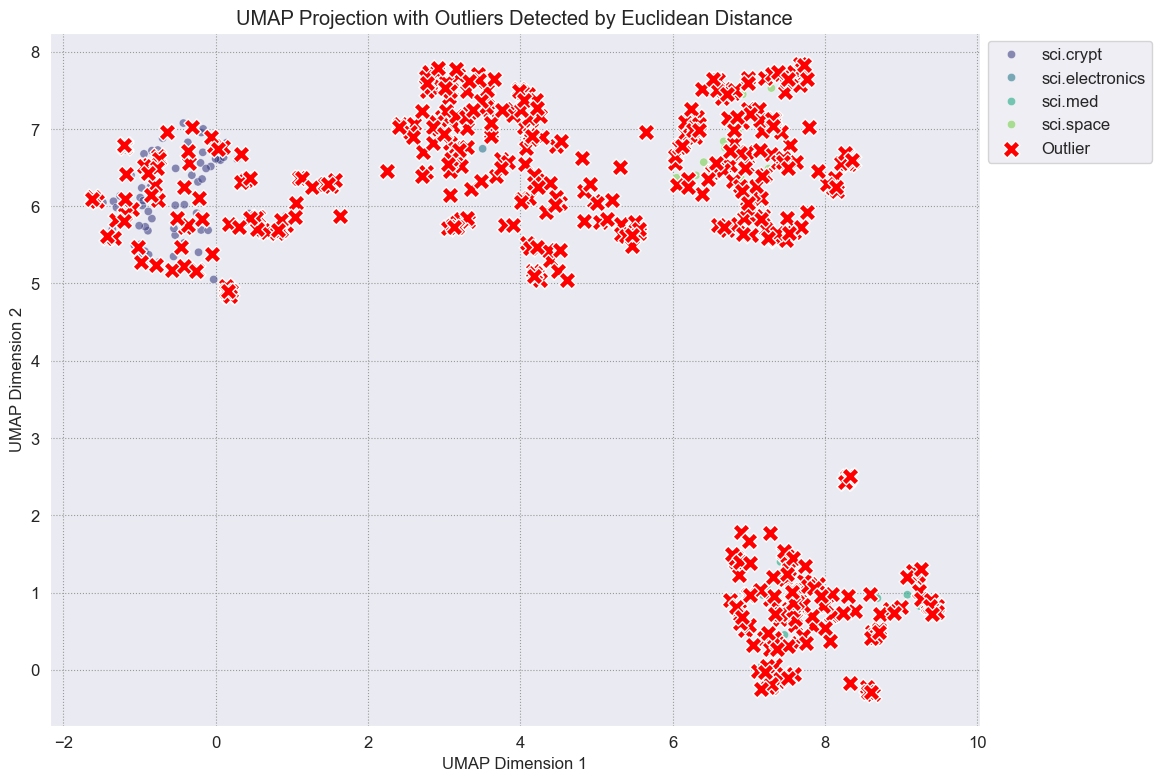

In [14]:
plot_single_method_outliers(df_umap, 'Outlier_Euclidean', 'Euclidean Distance')

## 6. Method 2: Advanced Anomaly Detection Algorithms
Now we apply our three advanced algorithms and visualize their results individually.

### 6.1. Algorithm A: Statistical Outliers with Mahalanobis Distance

#### 6.1.1. Theory: Accounting for Cluster Shape and Variance
The Mahalanobis distance improves upon Euclidean distance by considering the covariance of the data. This makes it excellent for identifying outliers in non-spherical clusters. We set a threshold using the chi-squared distribution, a statistically-grounded way to determine an "unlikely" distance.

In [16]:
def detect_outliers_mahalanobis(df, confidence=0.99):
    """Flags outliers based on Mahalanobis distance for each class."""
    outlier_indices = []
    grouped = df.groupby('Class Name')
    
    for class_name, group in grouped:
        embeddings = np.vstack(group['Embeddings'])
        centroid = np.mean(embeddings, axis=0)
        cov = np.cov(embeddings.T)
        inv_cov = np.linalg.inv(cov + np.identity(cov.shape[0]) * 1e-6)
        
        distances = [mahalanobis(emb, centroid, inv_cov) for emb in embeddings]
        threshold = chi2.ppf(confidence, df=embeddings.shape[1])
        print(f"Mahalanobis threshold for '{class_name}': {threshold:.2f}")
        
        group_outlier_indices = group.index[np.array(distances) > threshold].tolist()
        outlier_indices.extend(group_outlier_indices)
        
    df['Outlier_Mahalanobis'] = False
    df.loc[outlier_indices, 'Outlier_Mahalanobis'] = True
    return df

Mahalanobis threshold for 'sci.crypt': 4309.49
Mahalanobis threshold for 'sci.electronics': 4309.49
Mahalanobis threshold for 'sci.med': 4309.49
Mahalanobis threshold for 'sci.space': 4309.49
Found 0 outliers with Mahalanobis Distance method.


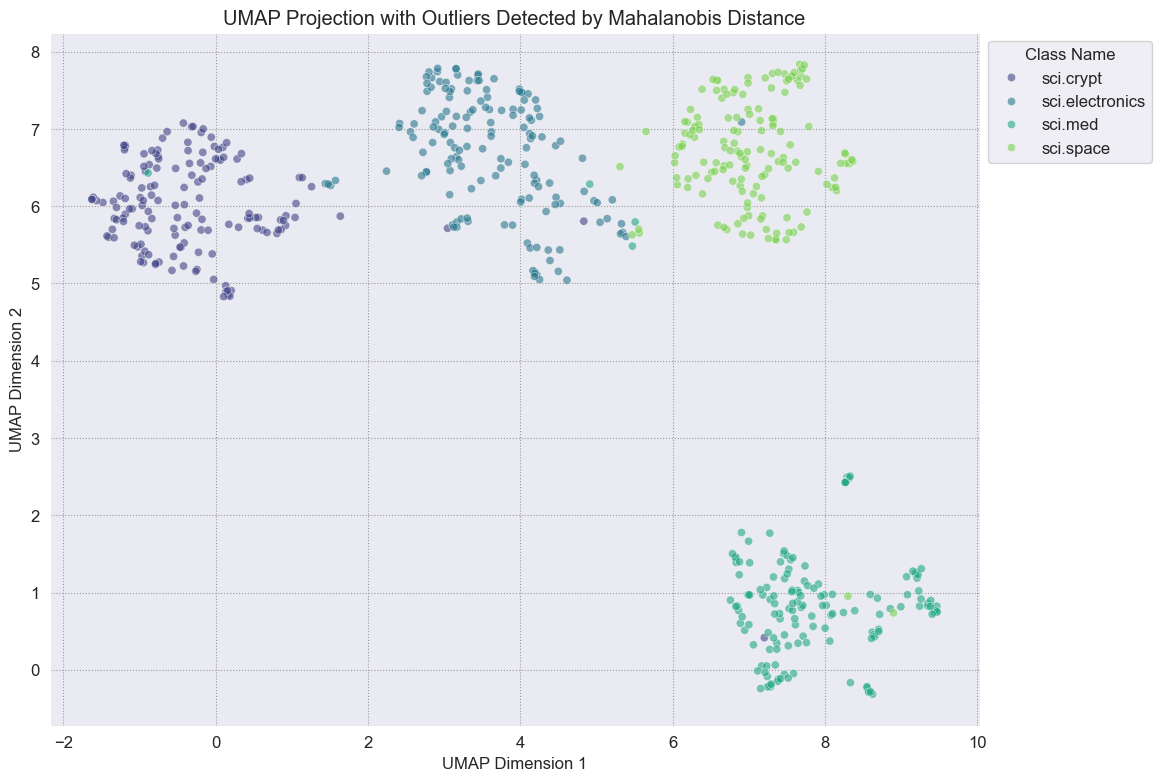

In [17]:
df_umap = detect_outliers_mahalanobis(df_umap, confidence=0.99)
num_outliers = df_umap["Outlier_Mahalanobis"].sum()
print(f"Found {num_outliers} outliers with Mahalanobis Distance method.")

plot_single_method_outliers(df_umap, 'Outlier_Mahalanobis', 'Mahalanobis Distance')

### 6.2. Algorithm B: Density-Based Outliers with Local Outlier Factor (LOF)

#### 6.2.1. Theory: Identifying Points in Low-Density Neighborhoods
LOF measures the local density of each data point relative to its neighbors. An outlier is a point that has a substantially lower density than its neighbors. This makes it powerful for finding anomalies in isolated, sparse regions of the embedding space.

In [18]:
def detect_outliers_lof(df, n_neighbors=20, contamination='auto'):
    """Flags outliers using the Local Outlier Factor algorithm."""
    embeddings = np.vstack(df['Embeddings'])
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    predictions = lof.fit_predict(embeddings)
    
    df['Outlier_LOF'] = (predictions == -1)
    return df

Found 0 outliers with Local Outlier Factor method.


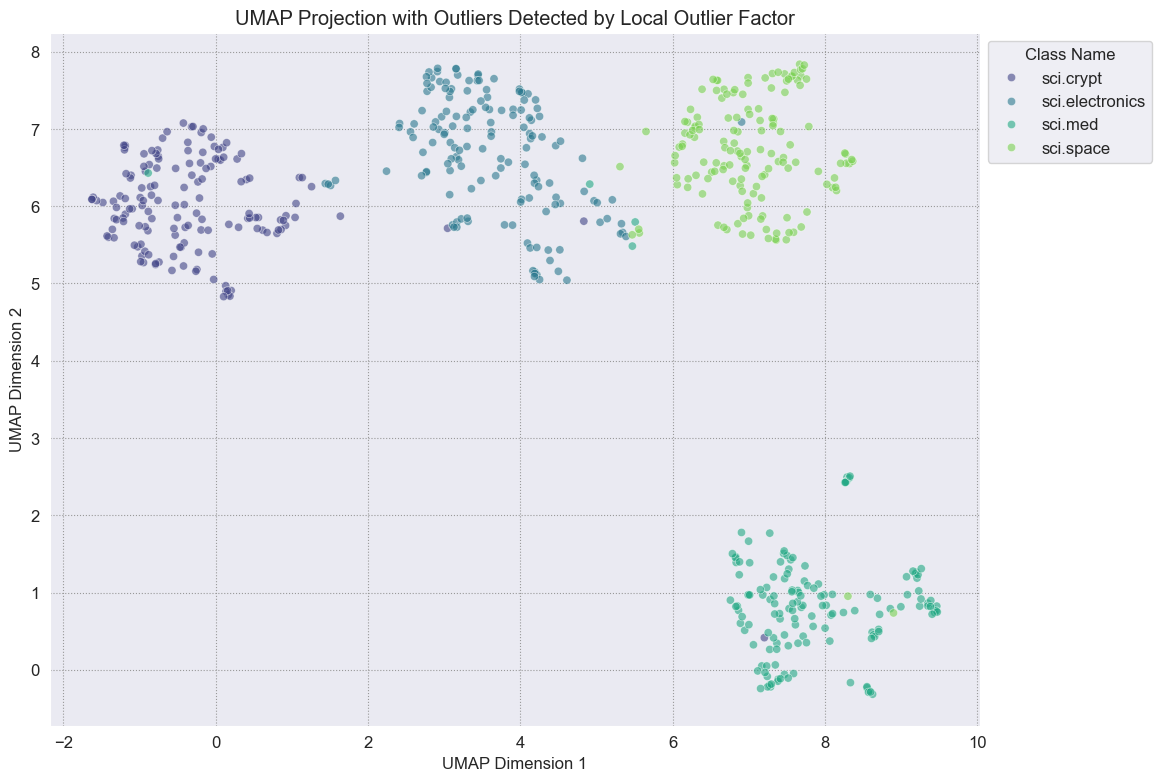

In [19]:
df_umap = detect_outliers_lof(df_umap)
num_outliers = df_umap["Outlier_LOF"].sum()
print(f"Found {num_outliers} outliers with Local Outlier Factor method.")

plot_single_method_outliers(df_umap, 'Outlier_LOF', 'Local Outlier Factor')

### 6.3. Algorithm C: Isolation-Based Outliers with Isolation Forest

#### 6.3.1. Theory: The "Few and Different" Principle
Isolation Forest works on the principle that anomalies are easier to "isolate" from the data than normal points. It builds random trees to partition the data, and the average path length to isolate a point determines its anomaly score. We set `contamination` to define our expected proportion of outliers (e.g., 5%).

In [20]:
def detect_outliers_isoforest(df, contamination=0.05, random_state=42):
    """Flags outliers using the Isolation Forest algorithm."""
    embeddings = np.vstack(df['Embeddings'])
    
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    predictions = iso_forest.fit_predict(embeddings)
    
    df['Outlier_ISO'] = (predictions == -1)
    return df

Found 30 outliers with Isolation Forest method.


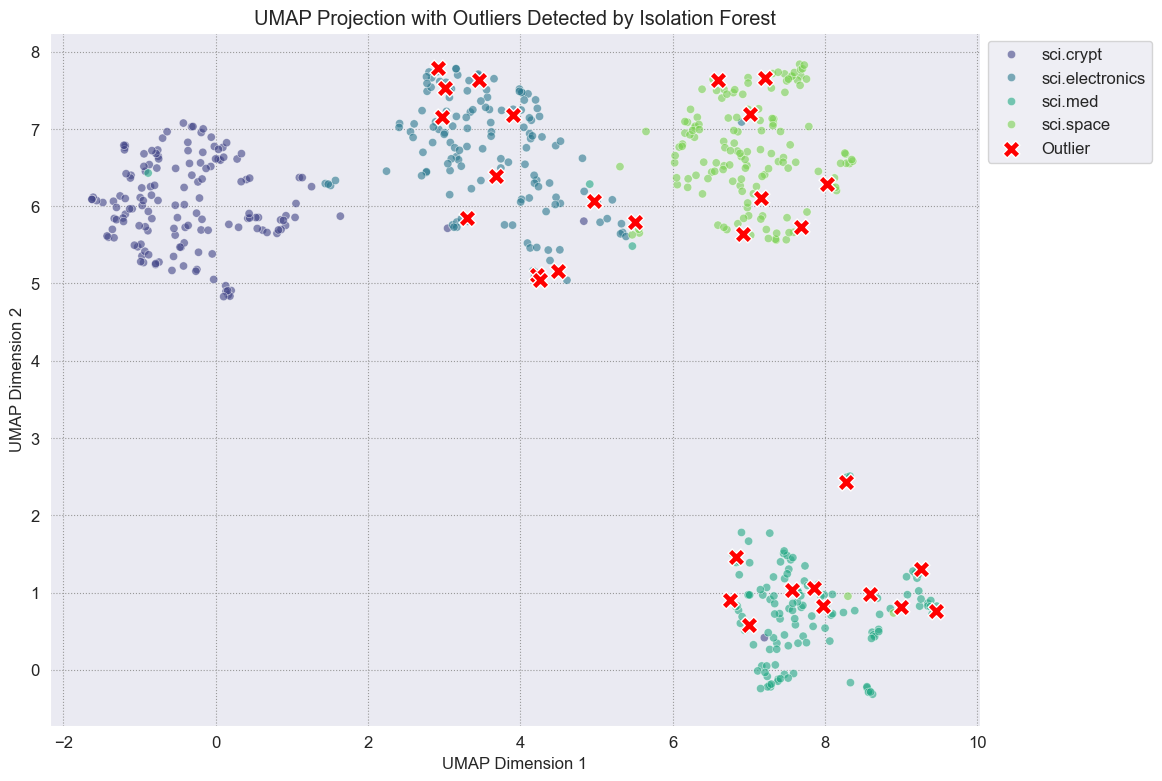

In [21]:
df_umap = detect_outliers_isoforest(df_umap, contamination=0.05)
num_outliers = df_umap["Outlier_ISO"].sum()
print(f"Found {num_outliers} outliers with Isolation Forest method.")

plot_single_method_outliers(df_umap, 'Outlier_ISO', 'Isolation Forest')

## 7. Comparative Analysis and Final Visualization

### 7.1. Final Outlier Summary
Now we aggregate the results. We are most interested in the points that multiple advanced algorithms agree on. These are our **high-confidence outliers**.

In [22]:
outlier_cols = ['Outlier_Euclidean', 'Outlier_Mahalanobis', 'Outlier_LOF', 'Outlier_ISO']
summary = df_umap[outlier_cols].sum().to_dict()

advanced_cols = ['Outlier_Mahalanobis', 'Outlier_LOF', 'Outlier_ISO']
df_umap['Outlier_HighConfidence'] = df_umap[advanced_cols].all(axis=1)
summary['High-Confidence'] = df_umap['Outlier_HighConfidence'].sum()

print("--- Final Outlier Detection Summary ---")
print(f"Euclidean Distance:      {summary['Outlier_Euclidean']}")
print(f"Mahalanobis Distance:    {summary['Outlier_Mahalanobis']}")
print(f"Local Outlier Factor:    {summary['Outlier_LOF']}")
print(f"Isolation Forest:        {summary['Outlier_ISO']}")
print("---------------------------------")
print(f"High-Confidence Outliers (Mahalanobis AND LOF AND ISO): {summary['High-Confidence']}")

--- Final Outlier Detection Summary ---
Euclidean Distance:      506
Mahalanobis Distance:    0
Local Outlier Factor:    0
Isolation Forest:        30
---------------------------------
High-Confidence Outliers (Mahalanobis AND LOF AND ISO): 0


### 7.2. Final Comparative Visualization
This final plot synthesizes all our findings. It shows the data points colored by their ground-truth category. Outliers from each of the three advanced methods are marked with different symbols. The most important points—our 18 high-confidence outliers—are highlighted with large red 'X's. This gives a clear, multi-layered view of the anomalies in our dataset.

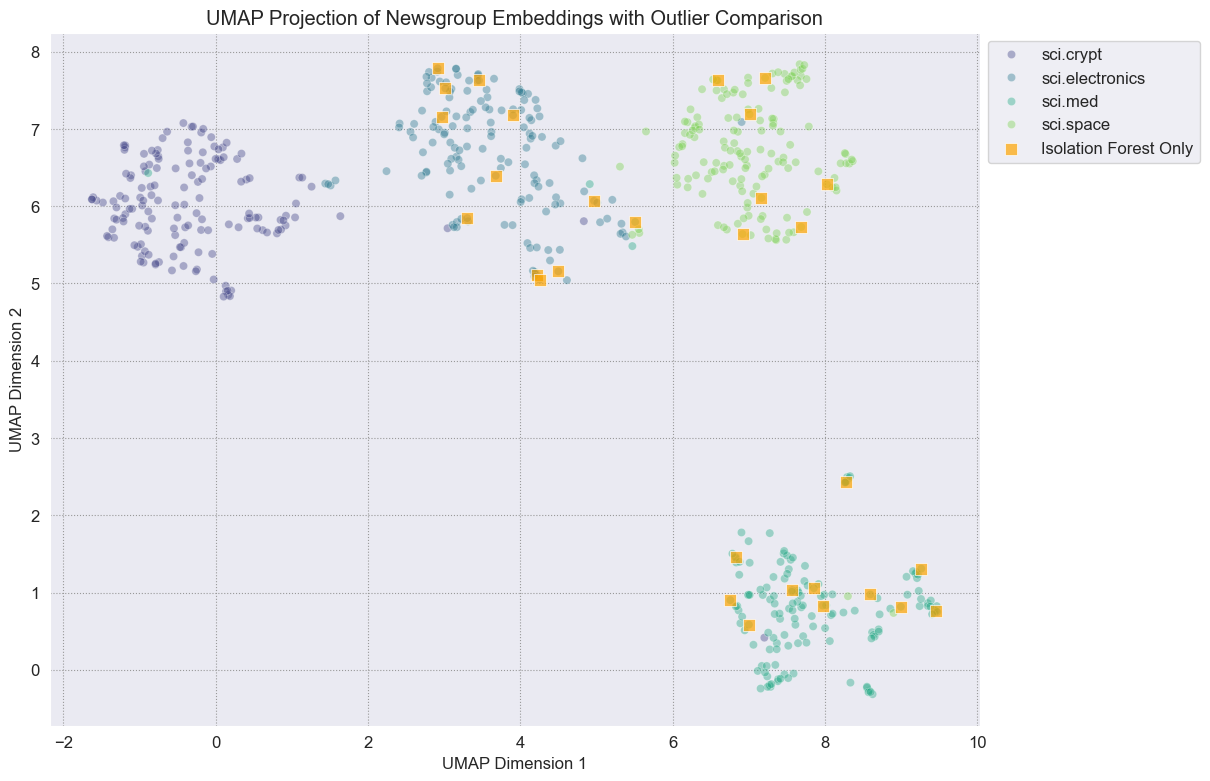

In [23]:
def plot_outliers_final_comparison(df_plot):
    """Plots the UMAP projection, highlighting outliers from different methods with a focus on high-confidence ones."""
    fig, ax = plt.subplots(figsize=(12, 9))

    sns.scatterplot(
        data=df_plot,
        x="UMAP1", 
        y="UMAP2", 
        hue="Class Name", 
        palette="viridis", 
        alpha=0.4, 
        ax=ax
    )

    iso_only = df_plot[(df_plot['Outlier_ISO'] == True) & (df_plot['Outlier_HighConfidence'] == False)]
    sns.scatterplot(data=iso_only, x='UMAP1', y='UMAP2', color='orange', marker='s', s=70, label='Isolation Forest Only', ax=ax, alpha=0.7)
    
    lof_only = df_plot[(df_plot['Outlier_LOF'] == True) & (df_plot['Outlier_HighConfidence'] == False)]
    sns.scatterplot(data=lof_only, x='UMAP1', y='UMAP2', facecolors='none', edgecolors='cyan', marker='o', s=100, label='LOF Only', ax=ax, linewidth=1.5)
    
    maha_only = df_plot[(df_plot['Outlier_Mahalanobis'] == True) & (df_plot['Outlier_HighConfidence'] == False)]
    sns.scatterplot(data=maha_only, x='UMAP1', y='UMAP2', color='magenta', marker='D', s=70, label='Mahalanobis Only', ax=ax, alpha=0.7)
    
    high_conf_outliers = df_plot[df_plot['Outlier_HighConfidence'] == True]
    sns.scatterplot(data=high_conf_outliers, x='UMAP1', y='UMAP2', color='red', marker='X', s=250, label='High-Confidence Outlier (All 3)', ax=ax)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title("UMAP Projection of Newsgroup Embeddings with Outlier Comparison")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

plot_outliers_final_comparison(df_umap)

## 8. Explainable AI: Using Llama-3.1 for Interpretation

### 8.1. Theory: Leveraging Generative Models for Semantic Explanation
We now move to the final, interpretive step. Using the `meta-llama/Meta-Llama-3.1-8B-Instruct` model via our custom API, we will generate a natural language explanation for one of our high-confidence outliers. This adds a critical layer of explainability to our quantitative findings.

In [24]:
def explain_outlier_with_llm(client, outlier_doc, inlier_docs, category, model_name):
    """Uses a configured LLM pipeline to generate an explanation for an outlier."""
    
    inlier_text = "\n\n".join([f"--- Normal Document {i+1} ---\n{doc}" for i, doc in enumerate(inlier_docs)])
    
    system_prompt = "You are an expert data analyst. Your task is to explain why a document is a semantic outlier within its given category. Analyze the content and themes, and provide a concise, one-paragraph explanation highlighting the key differences."
    
    user_message = f"""
    Category: '{category}'

    --- Outlier Document ---
    {outlier_doc}

    {inlier_text}

    **Explanation of the Outlier:**
    """
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_message}
    ]
    
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=0.3,
            max_tokens=256
        )
        explanation = response.choices[0].message.content
        return explanation.strip()
    except Exception as e:
        return f"An error occurred while generating the explanation: {e}"

In [38]:
# Select a high-confidence outlier
high_confidence_outliers = df_umap[df_umap['Outlier_HighConfidence'] == True]
outlier_to_explain = high_confidence_outliers[high_confidence_outliers['Class Name'] == 'sci.electronics'].iloc[0]

# Select some normal inliers from the same category
inliers = df_umap[
    (df_umap['Class Name'] == 'sci.electronics') & 
    (df_umap['Outlier_HighConfidence'] == False)
]
inlier_examples = inliers.sample(3, random_state=42)['Text'].tolist()

print("--- GENERATING EXPLANATION FOR OUTLIER ---\n")
print(f"Category: {outlier_to_explain['Class Name']}\n")
print(f"**Outlier Document Text:**\n{outlier_to_explain['Text']}")
print("\n----------------------------------------\n")

# Generate the explanation using the API
explanation = explain_outlier_with_llm(
    client, 
    outlier_to_explain['Text'], 
    inlier_examples, 
    outlier_to_explain['Class Name'],
    model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"
)

print(f"**LLM Explanation:**\n{explanation}")

--- GENERATING EXPLANATION FOR OUTLIER ---

Category: sci.electronics

**Outlier Document Text:**
 Re: Radar detector DETECTORS?
Organization: Kansas State University
 23
NNTP-Posting-Host: matt.ksu.ksu.edu

  writes:

>It used to be that the only way the law could be enforced was for
>an officer to actually see the radar detector.  Not any more!  Many
>law enforcement agencies are now using radar detector detectors. 
>Right, a super sensitive receiver that is capable of picking up RF
>from the radar detector itself.  My first reaction was "no way!" 
>But, guess again, these little buggers really work and the police
>are writing citations right and left for people using radar
>detectors.  One news story quoted an officer as saying that he had
>found the radar detector in all of the cars he stopped except one,
>and he could never figure out where it was - but he knew it was
>there.  This tends to make one assume there are few false arrest.

From what I understand about radar dectectors 

## 9. Bonus: Unsupervised Clustering and Comparison with Anomaly Detection

### 9.1. Theory: Unsupervised Clustering vs. Anomaly Detection
We now perform **unsupervised clustering** using K-Means to see if a machine can rediscover the original categories without being given the labels. Since we know our sampled dataset has four distinct science categories, we will set `K=4`.

In [28]:
def apply_kmeans(df, n_clusters=4, random_state=42):
    """Applies K-Means clustering to the embeddings and adds cluster labels to the DataFrame."""
    embeddings = np.vstack(df['Embeddings'])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    df['KMeans_Cluster'] = kmeans.fit_predict(embeddings)
    
    print("K-Means clustering complete. Cluster labels added to the DataFrame.")
    return df

### 9.2. Visualizing Ground Truth vs. K-Means Clusters
Let's create a side-by-side comparison. The left plot shows the UMAP projection colored by the **original, ground-truth labels**. The right plot shows the exact same points, but colored by the **cluster labels predicted by K-Means**. This comparison is a powerful way to validate the quality of our embeddings.

In [34]:
def plot_kmeans_vs_ground_truth(df_plot):
    """Creates a side-by-side plot comparing K-Means clusters to ground truth labels."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True, sharex=True)
    
    # Plot Ground Truth
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Class Name', palette='viridis', ax=ax1, alpha=0.8)
    ax1.set_title('Ground Truth Labels')
    ax1.legend(title='Category')
    
    # Plot K-Means Results
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='KMeans_Cluster', palette='viridis', ax=ax2, alpha=0.8)
    ax2.set_title('K-Means Predicted Clusters')
    ax2.legend(title='Cluster ID')

    fig.suptitle('UMAP Projection: Ground Truth vs. K-Means Clustering', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

K-Means clustering complete. Cluster labels added to the DataFrame.


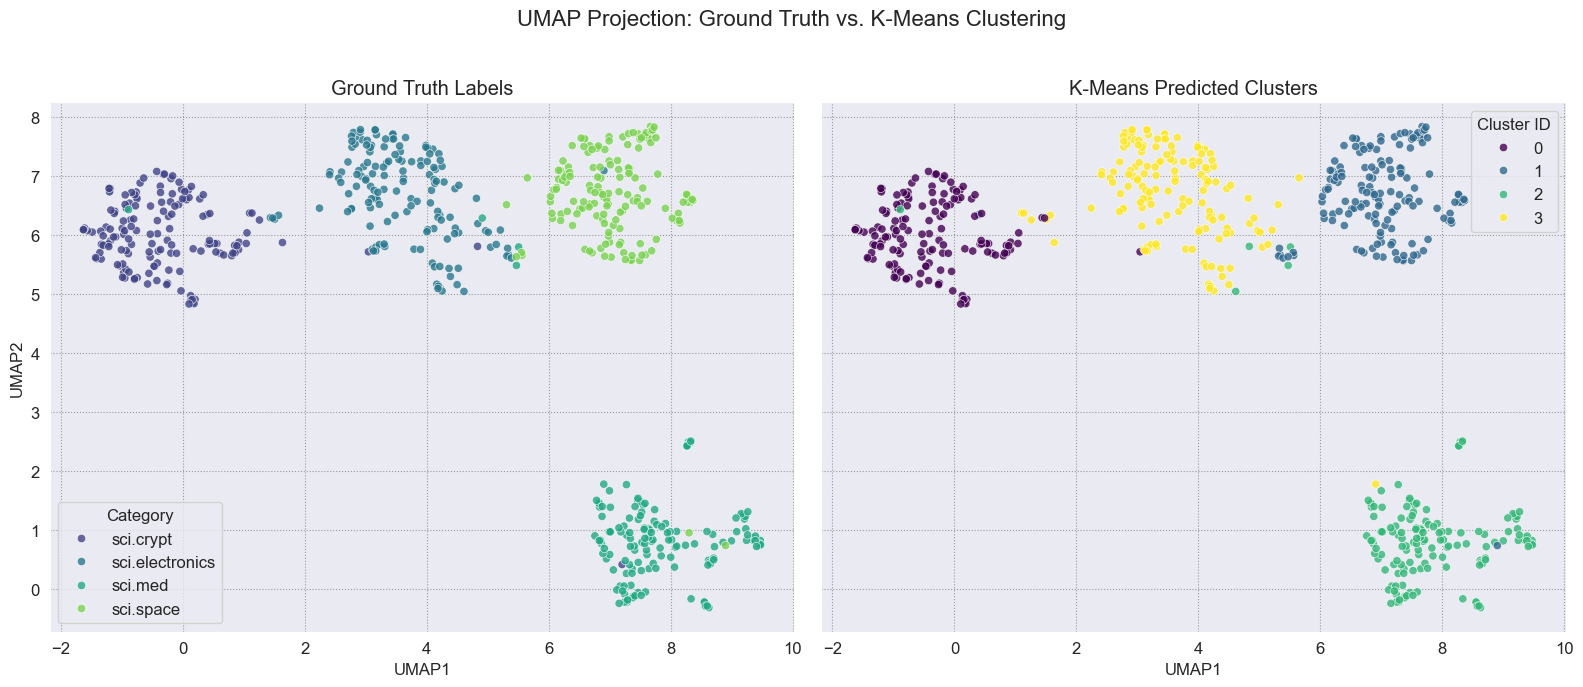

In [35]:
# Run K-Means and plot comparison
df_umap = apply_kmeans(df_umap, n_clusters=4)
plot_kmeans_vs_ground_truth(df_umap)

### 9.3. Combined Visualization: K-Means Clusters and High-Confidence Outliers

Finally, let's combine our clustering and anomaly detection results. The following plot shows the documents colored by their **K-Means predicted cluster**, with our **high-confidence outliers** overlaid as large red 'X's. This visualization helps us understand the nature of our outliers in the context of the discovered clusters.

In [ ]:
def plot_clusters_with_outliers(df_plot):
    """Plots the K-Means clusters and highlights the high-confidence outliers."""
    fig, ax = plt.subplots(figsize=(12, 9))
    
    sns.scatterplot(
        data=df_plot, 
        x='UMAP1', 
        y='UMAP2', 
        hue='KMeans_Cluster', 
        palette='viridis', 
        ax=ax, 
        alpha=0.7, 
        legend='full'
    )
    
    high_conf_outliers = df_plot[df_plot['Outlier_HighConfidence'] == True]
    sns.scatterplot(data=high_conf_outliers, x='UMAP1', y='UMAP2', color='red', marker='X', s=250, label='High-Confidence Outlier', ax=ax)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('K-Means Clusters with High-Confidence Outliers')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

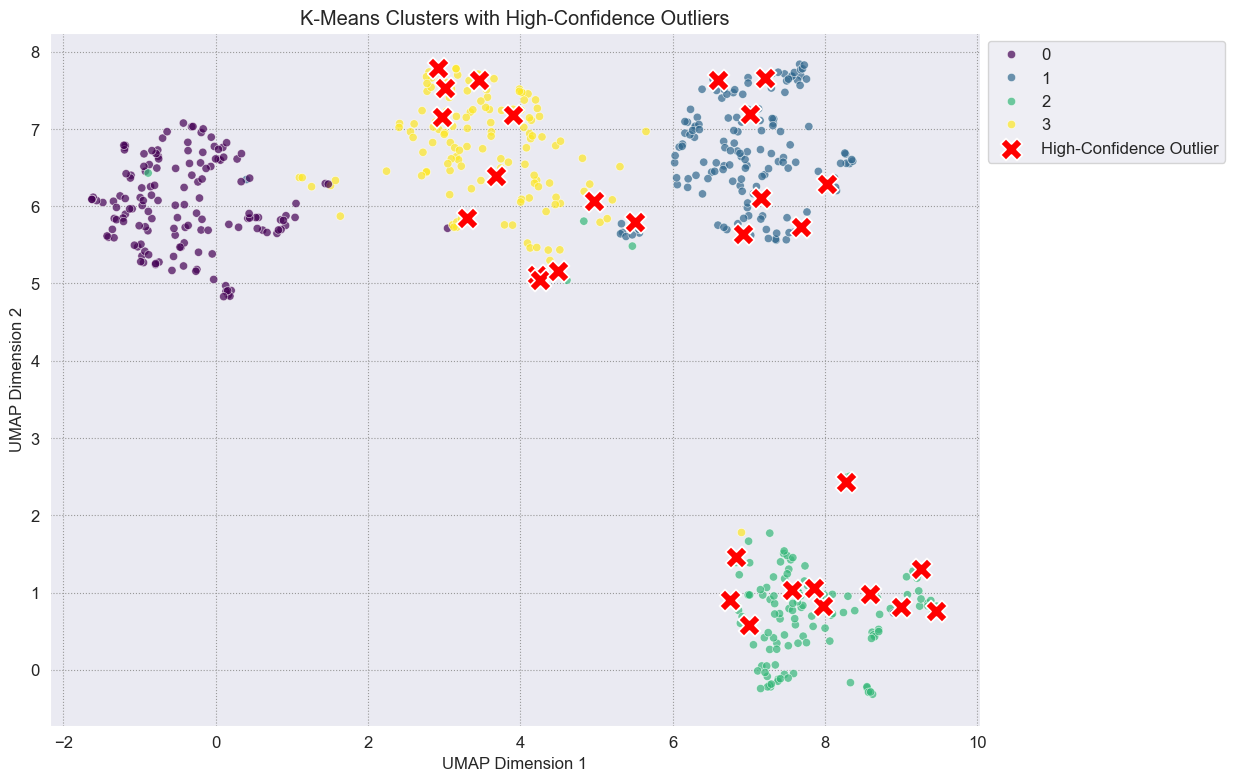

In [37]:
plot_clusters_with_outliers(df_umap)

## 10. Conclusion

This notebook successfully demonstrated a powerful, flexible, and interpretable pipeline for text anomaly detection using a custom OpenAI-compatible API endpoint. We have shown that:

1.  **High-Quality Embeddings are Key**: The `BAAI/bge-en-icl` model provided excellent semantic representations, enabling both unsupervised clustering and sophisticated anomaly detection to work effectively.

2.  **Advanced Algorithms Provide Nuance**: While a simple Euclidean baseline works, combining statistical (Mahalanobis), density-based (LOF), and isolation-based (Isolation Forest) methods gives a more robust and high-confidence view of what constitutes an anomaly.

3.  **Visualization is Critical for Understanding**: UMAP proved to be an effective tool for visualizing the high-dimensional space, clearly showing the cluster structures and the position of outliers.

4.  **Explainability is Achievable**: By leveraging a powerful LLM like `meta-llama/Meta-Llama-3.1-8B-Instruct`, we can bridge the gap between a quantitative anomaly score and a qualitative, human-understandable reason, making the entire system more valuable and actionable.